### In this notebook we define a logistic regression model to predict whether an individual experiences death or a severe injury in a crash. We will optimize the hyperparameters of the model to determine the best solver and inverse of the regularization strength for our model. Our goal is to maximize recall while still maintaining some level of accuracy. We will also look to maximize the AUC score. 

In [51]:
#Import packages
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import random
import warnings
warnings.filterwarnings("ignore")

In [52]:
#Read in data
df=pd.read_csv('data/df.csv')

First we will clean the data and define new columns for our analysis.

In [53]:
physical_condition_values = ['IMPAIRED - ALCOHOL', 'HAD BEEN DRINKING', 'IMPAIRED - DRUGS', 'IMPAIRED - ALCOHOL AND DRUGS', 'MEDICATED']
cause_values = ['HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)', 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)']

df['Under_Influence'] = ((df['PHYSICAL_CONDITION'].isin(physical_condition_values)) |
                         (df['PRIM_CONTRIBUTORY_CAUSE'].isin(cause_values)) |
                         (df['SEC_CONTRIBUTORY_CAUSE'].isin(cause_values)) |
                         ((df['BAC_RESULT_VALUE'] > 0.00) & (df['AGE'] < 21)) |
                         ((df['BAC_RESULT_VALUE'] >= 0.08) & (df['AGE'] >= 21))).astype(int)
#Drop unnecessary column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

#Set age values to null when data shows a driver under 12 years old
df['AGE'] = df['AGE'].abs()
df.loc[(df['AGE'] == 0.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan
df.loc[(df['AGE'] < 12.0) & (df['PERSON_TYPE'] == 'DRIVER'), 'AGE'] = np.nan

df.loc[df['BAC_RESULT']=="TEST PERFORMED, RESULTS UNKNOWN", 'BAC_RESULT']='TEST TAKEN'

#Change nulls to 0 for injury columns with missing data
df['INJURIES_FATAL'].fillna(0, inplace=True)
df['INJURIES_INCAPACITATING'].fillna(0, inplace=True)
df['Total_Serious_Injuries']=df['INJURIES_FATAL']+df['INJURIES_INCAPACITATING']
df['Has_Serious_Injury']=df['Total_Serious_Injuries'].apply(lambda x: 1 if x>0 else 0)

In [54]:
#Separate our X and y variables
y=df['Has_Serious_Injury']
X=df[['PERSON_TYPE', 'SEX', 'AGE', 
       'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'BAC_RESULT', 'BAC_RESULT_VALUE',
       'is_driver', 'total_drivers_in_crash', 
       'CRASH_HOUR', 'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'ROAD_DEFECT', 'CRASH_TYPE',
       'HIT_AND_RUN_I', 'PRIM_CONTRIBUTORY_CAUSE', 'Under_Influence']]

In [55]:
#Train test split
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=10)

In [56]:
#Impute median BAC value when test was taken and result not recorded. If test was not offered impute 0
bac_median=X_train['BAC_RESULT_VALUE'].median()
X_train.loc[X_train['BAC_RESULT_VALUE'].isna(), 'BAC_RESULT_VALUE']=X_train['BAC_RESULT'].apply(lambda x: 0 if x=='TEST NOT OFFERED' else bac_median)
X_test.loc[X_test['BAC_RESULT_VALUE'].isna(), 'BAC_RESULT_VALUE']=X_test['BAC_RESULT'].apply(lambda x: 0 if x=='TEST NOT OFFERED' else bac_median)

#Clean up columns with redundant different values
X_train['DRIVER_ACTION'].fillna('UNKNOWN', inplace=True)
X_train['DRIVER_ACTION']=X_train['DRIVER_ACTION'].apply(lambda x: 'UNKNOWN' if x=='NONE' else x)

X_test['DRIVER_ACTION'].fillna('UNKNOWN', inplace=True)
X_test['DRIVER_ACTION']=X_test['DRIVER_ACTION'].apply(lambda x: 'UNKNOWN' if x=='NONE' else x)

X_train['DRIVER_VISION']=X_train['DRIVER_VISION'].apply(lambda x: 'NOT OBSCURED' if x in ['UNKNOWN', 'OTHER'] else x)
X_train['DRIVER_VISION'].fillna('NOT OBSCURED', inplace=True)

X_test['DRIVER_VISION']=X_test['DRIVER_VISION'].apply(lambda x: 'NOT OBSCURED' if x in ['UNKNOWN', 'OTHER'] else x)
X_test['DRIVER_VISION'].fillna('NOT OBSCURED', inplace=True)

#Use BAC result to determine whether someone is drunk, impaired, or sober
def alcohol_use(x):
    if x>0 and x<0.08:
        return 'HAD BEEN DRINKING'
    elif x>=0.08:
        return 'IMPAIRED - ALCOHOL'
    elif x==0:
        return 'NORMAL'
X_train.loc[X_train['PHYSICAL_CONDITION'].isna(), 'PHYSICAL_CONDITION']=X_train['BAC_RESULT_VALUE'].apply(alcohol_use)
X_test.loc[X_test['PHYSICAL_CONDITION'].isna(), 'PHYSICAL_CONDITION']=X_test['BAC_RESULT_VALUE'].apply(alcohol_use)

y_train.reset_index(drop=True, inplace=True)

#Impute missing sex values based on distribution of data.
n_males=X_train['SEX'].value_counts()['M']
n_females=X_train['SEX'].value_counts()['F']
def sex_fixer(x):
    r=random.randint(1, n_males+n_females)
    if r<=n_males:
        return 'M'
    else:
        return 'F'
    
X_train.loc[X_train['SEX'].isna(), 'SEX']=X_train.loc[X_train['SEX'].isna(), 'SEX'].apply(sex_fixer)
X_train.loc[X_train['SEX']=='X', 'SEX']=X_train.loc[X_train['SEX']=='X', 'SEX'].apply(sex_fixer)

X_test.loc[X_test['SEX'].isna(), 'SEX']=X_test.loc[X_test['SEX'].isna(), 'SEX'].apply(sex_fixer)
X_test.loc[X_test['SEX']=='X', 'SEX']=X_test.loc[X_test['SEX']=='X', 'SEX'].apply(sex_fixer)

In [57]:
#Select the numeric and categorical columns we will use, and create encoded dataframe.

ohe=OneHotEncoder(sparse=False, drop='first')

X_train_categoricals=X_train[['PERSON_TYPE', 'DRIVER_ACTION', 'LIGHTING_CONDITION', 'CRASH_TYPE', 'SEX']]
X_test_categoricals=X_test[['PERSON_TYPE', 'DRIVER_ACTION', 'LIGHTING_CONDITION', 'CRASH_TYPE', 'SEX']]

X_train_categoricals_encoded=pd.DataFrame(ohe.fit_transform(X_train_categoricals))
X_test_categoricals_encoded=pd.DataFrame(ohe.transform(X_test_categoricals))
X_train_categoricals_encoded=X_train_categoricals_encoded.apply(np.float32)
X_test_categoricals_encoded=X_test_categoricals_encoded.apply(np.float32)

X_train_numeric=X_train[['is_driver', 'total_drivers_in_crash', 'POSTED_SPEED_LIMIT', 'Under_Influence']]
X_train_numeric.reset_index(drop=True, inplace=True)
X_train_numeric=X_train_numeric.apply(np.float32)

X_test_numeric=X_test[['is_driver', 'total_drivers_in_crash', 'POSTED_SPEED_LIMIT', 'Under_Influence']]
X_test_numeric.reset_index(drop=True, inplace=True)
X_test_numeric=X_test_numeric.apply(np.float32)

X_train_encoded=pd.merge(X_train_numeric, X_train_categoricals_encoded, left_index=True, right_index=True)
X_test_encoded=pd.merge(X_test_numeric, X_test_categoricals_encoded, left_index=True, right_index=True)

In [58]:
#Oversample minority class (0, which represents no injury or death) to balance data.
sm=SMOTE(random_state=10)
X_train_resampled, y_train_resampled=sm.fit_resample(X_train_encoded,y_train)

#Fit the first model
logreg=LogisticRegression(random_state=10)
logreg.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=10)

In [59]:
#Display metrics
y_preds=logreg.predict(X_test_encoded)
print(f'Accuracy score: {accuracy_score(y_test, y_preds)}')
print(f'Precision score: {precision_score(y_test, y_preds)}')
print(f'Recall score: {recall_score(y_test, y_preds)}')
print(f'F1 score score: {f1_score(y_test, y_preds)}')

y_score=logreg.decision_function(X_test_encoded)
roc_auc_score(y_test, y_score)

Accuracy score: 0.7000136502206785
Precision score: 0.0746507471624669
Recall score: 0.9997493734335839
F1 score score: 0.13892782822961924


0.8752804096287629

In [60]:
#Optimize hyperparameters using grid search
C=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver=['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
parameters={'C': C, 'solver': solver}

clf=GridSearchCV(logreg, parameters)
clf.fit(X_train_resampled[:10000], y_train_resampled[:10000])
best_c, best_solver=clf.best_params_['C'], clf.best_params_['solver']

Accuracy score: 0.6999590493379643
Precision score: 0.07464613484764854
Recall score: 0.999874686716792
F1 score score: 0.13892105056976956
ROC-AUC score: 0.8750673441301


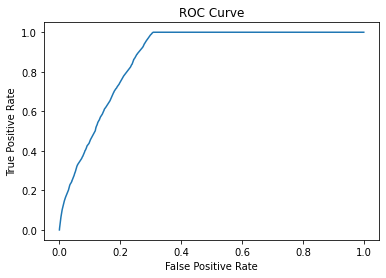

In [61]:
#Updating the logistic regression model to have the optimized parameters:
logreg_2=LogisticRegression(C=best_c, solver=best_solver, random_state=10)
logreg_2.fit(X_train_resampled, y_train_resampled)

#Display metrics
y_preds=logreg_2.predict(X_test_encoded)
print(f'Accuracy score: {accuracy_score(y_test, y_preds)}')
print(f'Precision score: {precision_score(y_test, y_preds)}')
print(f'Recall score: {recall_score(y_test, y_preds)}')
print(f'F1 score score: {f1_score(y_test, y_preds)}')

y_score=logreg_2.decision_function(X_test_encoded)
print(f'ROC-AUC score: {roc_auc_score(y_test, y_score)}')

#Display ROC Curve
y_predicted=logreg_2.predict_proba(X_test_encoded)[::,1]
fpr, tpr, results=roc_curve(y_test, y_predicted)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

In [62]:
#Create dictionary showing model coefficients
coefficients={}
for n in range (len(X_train_numeric.columns)):
    coefficients[X_train_numeric.columns[n]]=np.exp(logreg_2.coef_[0][n])
features=X_train_categoricals.columns
start=len(X_train_numeric.columns)
stop=len(X_train_numeric.columns)
for f in features:
    stop+=len(X_train[f].value_counts())-1
    coefficients[f]=np.exp(logreg_2.coef_[0][start:stop])
    start=stop

coefficients

{'is_driver': 0.6720572022352019,
 'total_drivers_in_crash': 1.0276834782833586,
 'POSTED_SPEED_LIMIT': 1.015288293624969,
 'Under_Influence': 1.339577712892011,
 'PERSON_TYPE': array([0.6720572 , 0.96532568, 0.92839244, 0.62225804, 1.89333289]),
 'DRIVER_ACTION': array([1.2959258 , 1.07023889, 1.10034356, 1.3477003 , 0.71652983,
        1.04854716, 0.96725524, 0.92755931, 0.86729362, 0.86691131,
        0.99722928, 1.19888941, 0.91290744, 1.00290605, 0.9584414 ,
        1.27148597, 1.04288694, 1.1868185 ]),
 'LIGHTING_CONDITION': array([1.12911759, 1.11782621, 0.98758305, 0.94057684, 0.68831148]),
 'CRASH_TYPE': array([0.00330411]),
 'SEX': array([1.08538053])}

## Findings from model:

In [63]:
driver_reduction=round(1-coefficients['is_driver'], 2)*100
dui_increase=round(coefficients['Under_Influence']-1, 2)*100
sex_increase=round(coefficients['SEX'][0]-1, 2)*100

print(f'Drivers experience a {driver_reduction}% reduction in their odds of death/severe injury compared to passengers and cyclists.')
print(f'A driver being under the influence raises the odds of a death/severe injury occurring by {dui_increase}%.')
print(f'Men have {sex_increase}% higher odds of death/severe injury than women.')

Drivers experience a 33.0% reduction in their odds of death/severe injury compared to passengers and cyclists.
A driver being under the influence raises the odds of a death/severe injury occurring by 34.0%.
Men have 9.0% higher odds of death/severe injury than women.
